In [2]:
import sys 
import matplotlib.pyplot as plt

pml = pulsedmeasurementlogic
pmal = pulsedmasterlogic
import pprint

import logic.pulsed.pulse_objects as po
import logic.pulsed.sampling_function_defs.basic_sampling_functions as functions
import time
import os

from tqdm import tqdm

PODMR - repetitions at each point

Necessary classes and functions

In [70]:
class PulseSequence:
    '''
    A pulse sequence to be loaded that is made of PulseBlock instances. The pulse blocks can be repeated
    as well and multiple can be added.
    '''
    def __init__(self):
        self.pulse_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}

    def append(self, block_list):
        '''
        append a list of tuples of type: 
        [(PulseBlock_instance_1, n_repetitions), (PulseBlock_instance_2, n_repetitions)]
        '''
        for block, n in block_list:
            for i in range(n):
                for key in block.block_dict.keys():
                    self.pulse_dict[key].extend(block.block_dict[key])

    
class PulseBlock:
    '''
    Small repeating pulse blocks that can be appended to a PulseSequence instance
    '''
    def __init__(self):
        self.block_dict = {'d0':[], 'd1':[], 'd2':[], 'd3':[], 'd4':[], 'd5':[], 'd6':[], 'd7':[], 'a0':[], 'a1':[]}
    
    def append(self, init_length, channels, repetition):
        '''
        init_length in s; will be converted by sequence class to ns
        channels are digital channels of PS in swabian language
        '''
        for i in range(repetition):
            for chn in channels.keys():
                self.block_dict[chn].extend([(init_length/1e-9, channels[chn])])

def set_up_odmr(pi_pulse=100e-9):
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._mw_switch)] = 1.0
    block_1.append(init_length = pi_pulse, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[d_ch(pulsestreamer._laser_channel)] = 1.0
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_start)] = 1.0 # pulse to TT channel detect
    block_1.append(init_length = 3e-6, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1.5e-6, channels = channels, repetition = 1)

    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

def set_up_next_trigger():
    """ 
    @param float clock_frequency: if defined, this sets the frequency of the
                                  clock
    @param str clock_channel: if defined, this is the physical channel of
                              the clock

    @return int: error code (0:OK, -1:error)
    """
    channels = {'d0': 0.0 , 'd1': 0.0 , 'd2': 0.0 , 'd3': 0.0 , 'd4': 0.0 , 'd5': 0.0 , 'd6': 0.0 , 'd7': 0.0 , 'a0': 0.0, 'a1': 0.0}
    clear = lambda x: {i:0.0 for i in x.keys()}
    d_ch = lambda x: f'd{x}'
    a_ch = lambda x: f'a{x}'

    seq = PulseSequence()
    block_1 = PulseBlock()

    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    channels[d_ch(pulsestreamer._pixel_stop)] = 1.0
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    channels = clear(channels)
    channels[a_ch(pulsestreamer._laser_analog_channel)] = pulsestreamer._laser_power_voltage
    block_1.append(init_length = 1e-3, channels = channels, repetition = 1)
    
    seq.append([(block_1, 1)])

    pulse_dict = seq.pulse_dict

    pulsestreamer.load_swabian_sequence(pulse_dict)
    return pulsestreamer._seq

Run measurement

In [5]:
var_list = np.linspace(2.84e9, 2.86e9, 5, endpoint=True)
mw_power = -13
pi_pulse=274e-9
num_runs = 200000

mw_source_smbv.set_list(var_list, mw_power) # 
mw_source_smbv.list_on()
laser_pulses = len(var_list)

bin_width_s = 1e-9
record_length_s = 3e-6

ret_val = time_tagger.configure_recorder(
                mode=11, # pulsed mode
                params={'laser_pulses': laser_pulses,
                        'bin_width_s': bin_width_s,
                        'record_length_s': record_length_s,
                        'max_counts': 1} )

time_tagger.start_recorder(arm=True)
set_up_next_trigger()

pulsestreamer.pulser_on(n=int(1))
while True:
    time.sleep(0.001)
    if pulsestreamer.pulse_streamer.hasFinished():
        break
podmr = set_up_odmr(pi_pulse)

for i in tqdm(range(laser_pulses)):
    pulsestreamer.pulser_on(n=num_runs, final=pulsestreamer._mw_trig_final_state)
    d =time.time()
    while True:
        if time_tagger.recorder.getHistogramIndex() > i or (time.time()-d)>2 or time_tagger.recorder.getCounts()>0:
            time.sleep(0.001)
            break

pulsestreamer.pulser_off()
mw_source_smbv.off()   

100%|#######################################################################################################################################################################################################################| 5/5 [00:05<00:00,  1.18s/it]


0

In [6]:
pulsed_meas = time_tagger.get_measurements()[0]

Plot Jupyter data

[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 5
    # variables        = 5
    chi-square         = 1.1207e-04
    reduced chi-square = inf
    Akaike info crit   = -43.5291657
    Bayesian info crit = -45.4819762
[[Variables]]
    l0_amplitude: -0.02180360 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l0_center:     2.8445e+09 +/- 0.00000000 (0.00%) (init = 2.845e+09)
    l0_sigma:      5000000.00 +/- 0.00000000 (0.00%) (init = 5000000)
    offset:        1.13553379 +/- 0.00000000 (0.00%) (init = 1.126217)
    l1_amplitude: -1.0034e-06 +/- 0.00000000 (0.00%) (init = -0.004175578)
    l1_center:     2.8475e+09 +/- 0.00000000 (0.00%) == 'l0_center+3030000.0'
    l1_sigma:      5000000.00 +/- 0.00000000 (0.00%) =

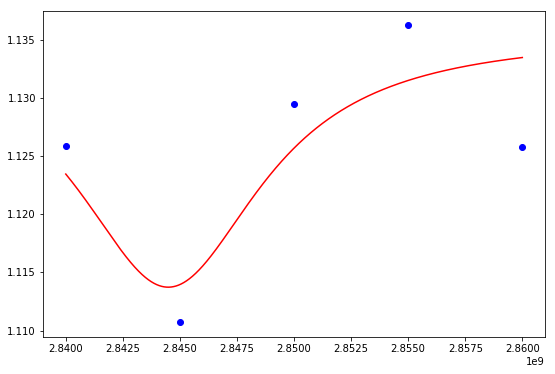

In [7]:
data,_ =afm_scanner_logic.analyse_pulsed_meas(pulsedmasterlogic.analysis_settings, pulsed_meas)

# fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
print(fit.fit_report())
# lm,_ = fitlogic.make_lorentzian_model()
lm,_ = fitlogic.make_lorentziandouble_model()
plt.plot(var_list, data,'bo')
x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')
plt.show()

Plot SPM data

In [3]:
d = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['data']
x = afm_scanner_logic._pulsed_scan_array['pulsed_fw']['coord2_arr']
data = d[0,0,:]

In [5]:
x

array([2.84000000e+09, 2.84051282e+09, 2.84102564e+09, 2.84153846e+09,
       2.84205128e+09, 2.84256410e+09, 2.84307692e+09, 2.84358974e+09,
       2.84410256e+09, 2.84461538e+09, 2.84512821e+09, 2.84564103e+09,
       2.84615385e+09, 2.84666667e+09, 2.84717949e+09, 2.84769231e+09,
       2.84820513e+09, 2.84871795e+09, 2.84923077e+09, 2.84974359e+09,
       2.85025641e+09, 2.85076923e+09, 2.85128205e+09, 2.85179487e+09,
       2.85230769e+09, 2.85282051e+09, 2.85333333e+09, 2.85384615e+09,
       2.85435897e+09, 2.85487179e+09, 2.85538462e+09, 2.85589744e+09,
       2.85641026e+09, 2.85692308e+09, 2.85743590e+09, 2.85794872e+09,
       2.85846154e+09, 2.85897436e+09, 2.85948718e+09, 2.86000000e+09])

In [37]:
x = np.linspace(2.84e9,2.86e9,40, endpoint=True)

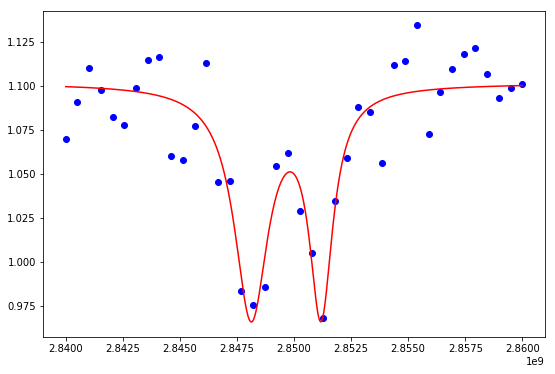

In [6]:
fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
# print(fit.fit_report())
lm,_ = fitlogic.make_lorentziandouble_model()
plt.plot(x, data,'bo')
x1 = np.linspace(x[0],x[-1],10000, endpoint=True)
plt.plot(x1, lm.eval(fit.params, x=x1),'r-')

plt.show()

In [39]:
(fit.params['l1_center']+fit.params['l0_center'])/2

2850308429.723922

In [7]:
fit_param = np.zeros((d.shape[0],d.shape[1]))
for i in tqdm(range(d.shape[0])):
    for j in range(d.shape[1]):
        data = d[i,j,:]
        fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(x,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
        fit_param[i,j] = (fit.params['l1_center']+fit.params['l0_center'])/2

100%|#######################################################################################################################################################################################################################| 9/9 [00:00<00:00, 10.37it/s]


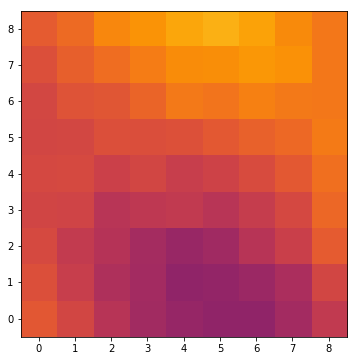

In [8]:
plt.imshow(fit_param, cmap=plt.get_cmap('inferno'), origin='lower',vmin=2850308429.723922-5e6, vmax=2850308429.723922+2e6)
plt.show()